In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from scipy.spatial import Delaunay
from collections import defaultdict
from itertools import combinations

import random

In [6]:
def create_grid(x_min, x_max, y_min, y_max, spacing):
    x_coords = np.arange(x_min, x_max + spacing, spacing)
    y_coords = np.arange(y_min, y_max + spacing, spacing)
    grid_points = [(x, y) for x in x_coords for y in y_coords]

    edge_points = set()
    for x in x_coords:
        edge_points.add((x, y_min))
        edge_points.add((x, y_max))
    for y in y_coords:
        edge_points.add((x_min, y))
        edge_points.add((x_max, y))

    return grid_points, list(edge_points)

def scale_boundary_points(boundary_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in boundary_points]
    return scaled_points

def rotate_boundary_points(boundary_points, angle, center):
    angle_rad = np.radians(angle)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)
    cx, cy = center
    rotated_points = []
    for x, y in boundary_points:
        x_new = cos_angle * (x - cx) - sin_angle * (y - cy) + cx
        y_new = sin_angle * (x - cx) + cos_angle * (y - cy) + cy
        rotated_points.append((x_new, y_new))
    return rotated_points

def translate_boundary_points(boundary_points, new_center):
    cx, cy = new_center
    ox, oy = 5, 5
    translated_points = [(x + cx - ox, y + cy - oy) for x, y in boundary_points]
    return translated_points

def is_valid_triangle(triangle, existing_triangles):
    for tri in existing_triangles:
        if triangle.intersects(Polygon(tri)) and triangle.intersection(Polygon(tri)).area > 0:
            return False
    return True

def find_connected_components(points, edges):
    adjacency_list = defaultdict(list)
    for edge in edges:
        adjacency_list[tuple(edge[0])].append(tuple(edge[1]))
        adjacency_list[tuple(edge[1])].append(tuple(edge[0]))

        visited = set()
        components = []

        def dfs(node, component):
            stack = [node]
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    component.append(current)
                    stack.extend(adjacency_list[current])

        for point in points:
            if tuple(point) not in visited:
                component = []
                dfs(tuple(point), component)
            components.append(component)

    return components

def create_mesh(edge_dem2, surrounding_points_dem1, filtered_triangles_dem1, corner_tri):
    combined_points = np.array(edge_dem2 + surrounding_points_dem1)
    delaunay = Delaunay(combined_points)

    valid_triangles = []
    deleted_triangles = []
    deleted_edges = []

    for simplex in delaunay.simplices:
        vertices = combined_points[simplex]
        in_edge = [tuple(v) in edge_dem2 for v in vertices]
        in_surrounding = [tuple(v) in surrounding_points_dem1 for v in vertices]
        triangle = Polygon(vertices)

        if any(in_edge) and any(in_surrounding):
            if not any(triangle.intersection(tri).area > 0 for tri in filtered_triangles_dem1) \
                and not any(triangle.intersection(tri2).area > 0.001 for tri2 in corner_tri):
                # if not any(triangle.intersection(tri2).area > 0 for tri2 in corner_tri):
                valid_triangles.append(vertices)
            else:
                deleted_triangles.append(triangle)
                deleted_edges.extend([(vertices[i], vertices[(i + 1) % 3]) for i in range(3)])

    unique_points = list(set(tuple(point) for tri in deleted_triangles for point in tri.exterior.coords[:-1]))
    components = find_connected_components(unique_points, deleted_edges)

    print(len(components))

    for component in components:
        if len(component) < 3:
            continue
        # component_points = np.array(component)
        # delaunay_component = Delaunay(component_points)
        # for simplex in delaunay_component.simplices:
        # vertices = np.array(component_points)[simplex]
        # new_triangle = Polygon(vertices)
        # if not any(new_triangle.intersection(tri).area > 0 for tri in filtered_triangles_dem1):
        # valid_triangles.append(vertices)
        for comb in combinations(component, 3):
            component_points = np.array(comb)
            print(component_points)
            delaunay_component = Delaunay(component_points)
            for simplex in delaunay_component.simplices:
                vertices = np.array(component_points)[simplex]
                new_triangle = Polygon(vertices)
                if not any(new_triangle.intersection(tri).area > 0 for tri in filtered_triangles_dem1) and \
                    not any(new_triangle.intersection(Polygon(valid_tri)).area > 0 for valid_tri in valid_triangles):
                    
                    area_check = True
                    for tri2 in corner_tri:
                        print(new_triangle.intersection(tri2).area)
                        if new_triangle.intersection(tri2).area > 0.0:
                            area_check = False
                            print("false")
                            break
                    
                    if area_check and is_valid_triangle(new_triangle, valid_triangles):
                        valid_triangles.append(vertices)
                        print("added!")
                    # not any(new_triangle.intersection(tri2).area > 0.001 for tri2 in corner_tri):
                    # and is_valid_triangle(new_triangle, valid_triangles)

    return valid_triangles, components

In [3]:
x_min, x_max, y_min, y_max = 0, 10, 0, 10
corners_dem2 = [(0, 0), (10, 0), (10, 10), (0, 10), (0, 0)]

spacing_dem1 = 0.3
spacing_dem2 = 0.25

scale_factor_dem1 = 3.0
scale_factor_dem2 = 1.0

grid_points_dem1, edge_dem1 = create_grid(x_min, x_max, y_min, y_max, spacing_dem1)
grid_points_dem2, edge_dem2 = create_grid(x_min, x_max, y_min, y_max, spacing_dem2)

boundary_points_dem1 = scale_boundary_points(grid_points_dem1, scale_factor_dem1)
boundary_points_dem2 = scale_boundary_points(grid_points_dem2, scale_factor_dem2)
corners_dem2 = scale_boundary_points(corners_dem2, scale_factor_dem2)
edge_dem2 = scale_boundary_points(edge_dem2, scale_factor_dem2)

# rotation_angle_dem2 = 40
# new_center_dem2 = (15,15)
# rotation_angle_dem2 = random.uniform(0, 360)
# new_center_dem2 = (random.uniform(10, 20), random.uniform(10, 20))
rotation_angle_dem2 = 9.750572222105184
new_center_dem2 = (15.522990931280127, 11.391868179027062)
print("rotation: ", rotation_angle_dem2)
print("new center: ", new_center_dem2)

boundary_points_dem2 = translate_boundary_points(boundary_points_dem2, new_center_dem2)
boundary_points_dem2 = rotate_boundary_points(boundary_points_dem2, rotation_angle_dem2, new_center_dem2)

corners_dem2 = translate_boundary_points(corners_dem2, new_center_dem2)
corners_dem2 = rotate_boundary_points(corners_dem2, rotation_angle_dem2, new_center_dem2)

edge_dem2 = translate_boundary_points(edge_dem2, new_center_dem2)
edge_dem2 = rotate_boundary_points(edge_dem2, rotation_angle_dem2, new_center_dem2)

dem1 = Delaunay(boundary_points_dem1)
dem2 = Delaunay(boundary_points_dem2)

tri_dem1 = [Polygon([boundary_points_dem1[simplex[0]], boundary_points_dem1[simplex[1]], boundary_points_dem1[simplex[2]]]) for simplex in dem1.simplices]
tri_dem2 = [Polygon([boundary_points_dem2[simplex[0]], boundary_points_dem2[simplex[1]], boundary_points_dem2[simplex[2]]]) for simplex in dem2.simplices]

rotation:  9.750572222105184
new center:  (15.522990931280127, 11.391868179027062)


In [7]:
surrounding_points_dem1 = []
filtered_triangles_dem1 = []
for tri in tri_dem1:
    if not Polygon(corners_dem2).intersects(tri):
        filtered_triangles_dem1.append(tri)
    else:
        for point in tri.exterior.coords:
            if not Polygon(corners_dem2).contains(Point(point)):
                surrounding_points_dem1.append(point)

corner_tri = Delaunay(corners_dem2)
corner_tri = [Polygon([corners_dem2[simplex[0]], corners_dem2[simplex[1]], corners_dem2[simplex[2]]]) for simplex in corner_tri.simplices]

mesh, components = create_mesh(edge_dem2, surrounding_points_dem1, filtered_triangles_dem1, corner_tri)

16
[[20.55839373  7.18387356]
 [21.17053999  8.05005885]
 [20.7         7.2       ]]
0.05579105086262548
false
[[20.55839373  7.18387356]
 [21.17053999  8.05005885]
 [19.8         6.3       ]]
[[20.55839373  7.18387356]
 [21.17053999  8.05005885]
 [21.6         7.2       ]]
[[20.55839373  7.18387356]
 [21.17053999  8.05005885]
 [20.80478232  7.2262134 ]]
0.09375000000000061
false
[[20.55839373  7.18387356]
 [21.17053999  8.05005885]
 [21.21287983  7.80367026]]
0.09374999999999997
false
[[20.55839373  7.18387356]
 [20.7         7.2       ]
 [19.8         6.3       ]]
[[20.55839373  7.18387356]
 [20.7         7.2       ]
 [21.6         7.2       ]]
[[20.55839373  7.18387356]
 [20.7         7.2       ]
 [20.80478232  7.2262134 ]]
0.0
0.0
added!
[[20.55839373  7.18387356]
 [20.7         7.2       ]
 [21.21287983  7.80367026]]
[[20.55839373  7.18387356]
 [19.8         6.3       ]
 [21.6         7.2       ]]
[[20.55839373  7.18387356]
 [19.8         6.3       ]
 [20.80478232  7.2262134 ]]
[[

In [13]:
print(components[0])

[(20.558393727687807, 7.1838735642574925), (21.17053999339427, 8.050058850083587), (20.7, 7.199999999999999), (19.799999999999997, 6.300000000000001), (21.599999999999998, 7.199999999999999), (20.804782319609902, 7.226213400944098), (21.212879830080876, 7.803670258161494)]


In [17]:
print(components[1])

[(20.558393727687807, 7.1838735642574925), (21.17053999339427, 8.050058850083587), (20.7, 7.199999999999999), (19.799999999999997, 6.300000000000001), (21.599999999999998, 7.199999999999999), (20.804782319609902, 7.226213400944098), (21.212879830080876, 7.803670258161494)]


In [16]:
print(components[15])

[(20.7, 10.799999999999999), (21.599999999999998, 9.899999999999999), (20.66246195315501, 11.006721953148702), (20.7, 11.7)]


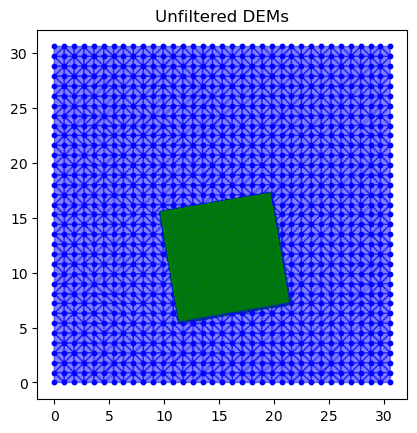

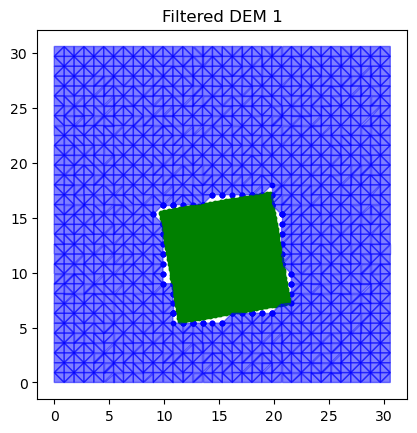

In [10]:
def plot_mesh(mesh, color, label):
    for tri in mesh:
        x = [point[0] for point in tri] + [tri[0][0]]
        y = [point[1] for point in tri] + [tri[0][1]]
        plt.fill(x, y, alpha=0.5, color=color, label=label)

def plot_triangles(triangles, color, label):
    for tri in triangles:
        x, y = tri.exterior.xy
        plt.fill(x, y, alpha=0.5, color=color, label=label)

plt.figure()
plt.scatter(*zip(*boundary_points_dem1), color='blue', label='DEM 1', s=10)
plt.scatter(*zip(*boundary_points_dem2), color='green', label='DEM 2', s=10)
plot_triangles(tri_dem1, 'blue', 'DEM1')
plot_triangles(tri_dem2, 'green', 'DEM2')
plt.title("Unfiltered DEMs")
plt.gca().set_aspect('equal', adjustable='box')

plt.figure()
plt.scatter(*zip(*surrounding_points_dem1), color='blue', label='DEM 1', s=10)
plt.scatter(*zip(*boundary_points_dem2), color='green', label='DEM 2', s=10)
plot_triangles(filtered_triangles_dem1, 'blue', 'DEM 1')
plot_triangles(tri_dem2, 'green', 'DEM2')
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Filtered DEM 1")
plt.show()

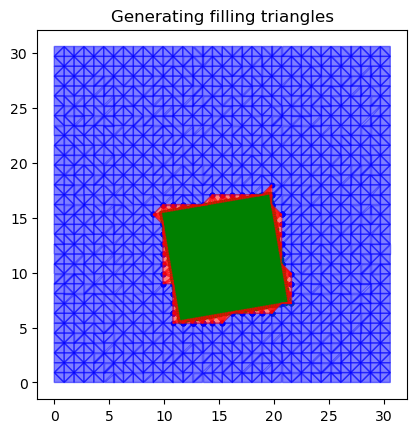

In [12]:
plt.figure()
plt.scatter(*zip(*surrounding_points_dem1), color='blue', label='DEM 1', s=10)
plt.scatter(*zip(*boundary_points_dem2), color='green', label='DEM 2', s=10)

plt.scatter(*zip(*components[0]), color='orange', label='DEM 2', s=10)
plt.scatter(*zip(*components[1]), color='teal', label='DEM 2', s=10)
# plt.scatter(*zip(*components), color='black', label='DEM 2', s=10)


plot_triangles(filtered_triangles_dem1, 'blue', 'DEM 1')
plot_triangles(tri_dem2, 'green', 'DEM2')
plot_mesh(mesh, 'red', 'fill')
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Generating filling triangles")
plt.show()